# integrating with Harmony

In [1]:
import scanpy as sc
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# let's silence all the annoying Future warnings from Pandas:
import pandas as pd

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_h5ad("./psilo_both.h5ad")

In [3]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.normalize_total(adata)

adata.raw = adata.copy()

sc.tl.pca(adata, n_comps=80, svd_solver="arpack")

In [4]:
sc.external.pp.harmony_integrate(adata, "condition")

2024-03-27 12:01:16,541 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-27 12:01:24,531 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-27 12:01:24,591 - harmonypy - INFO - Iteration 1 of 10
2024-03-27 12:01:28,869 - harmonypy - INFO - Iteration 2 of 10
2024-03-27 12:01:32,852 - harmonypy - INFO - Iteration 3 of 10
2024-03-27 12:01:36,169 - harmonypy - INFO - Converged after 3 iterations


In [5]:
adata

AnnData object with n_obs × n_vars = 25018 × 25328
    obs: 'condition', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

In [6]:
sc.pp.neighbors(adata, use_rep="X_pca_harmony")
sc.tl.umap(adata, min_dist=0.1)

In [7]:
sc.tl.leiden(adata, resolution=0.8)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


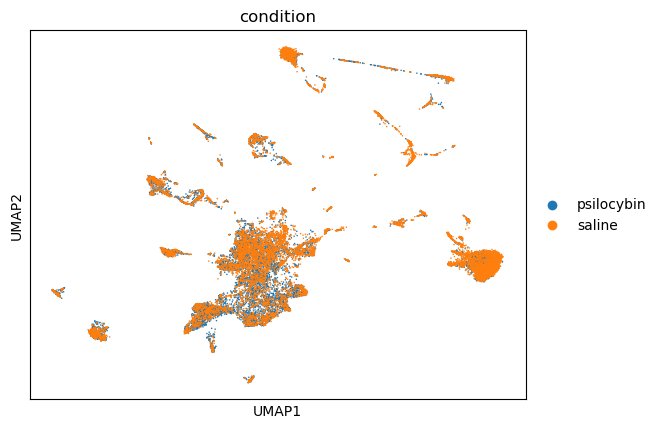

In [8]:
sc.pl.umap(adata, color="condition")

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


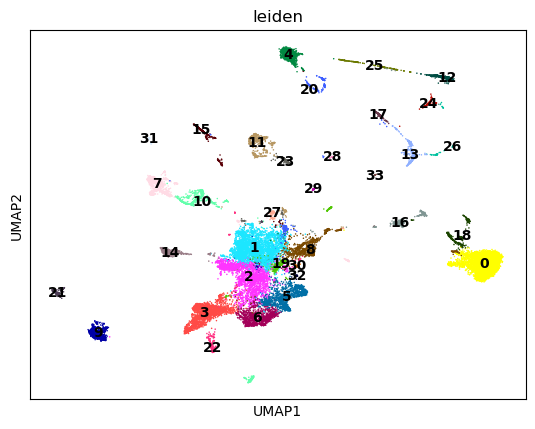

In [9]:
sc.pl.umap(adata, color="leiden", legend_loc="on data")

In [10]:
sc.tl.paga(adata)

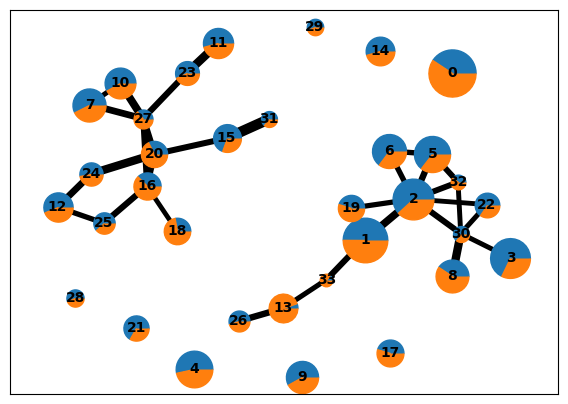

In [11]:
sc.pl.paga(adata, threshold=0.45, color="condition", node_size_scale=3,)

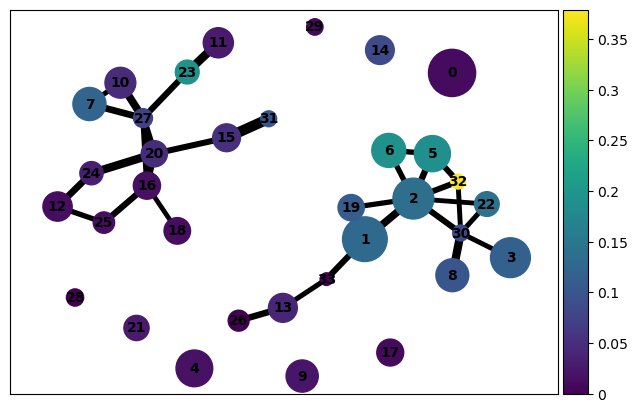

In [12]:
sc.pl.paga(adata, threshold=0.45, color="Htr2a", node_size_scale=3,)

In [13]:
sc.tl.dendrogram(adata, groupby="leiden", use_rep="X_pca_harmony")

# we would like to focus on a single cluster

let's say that's cluster 29. We can subset the AnnData object to only contain this one.

In [79]:
def get_counts(adata, gene):
    return adata[:, gene].X.toarray()[:, 0]
    
def compare_gene(adata, gene, cluster, clustering):
    keep = (adata.obs[clustering] == cluster)
    adata_cl = adata[keep]

    keep = adata_cl.obs["condition"] == "saline"
    adata_cl_saline = adata_cl[keep]
    
    keep = adata_cl.obs["condition"] == "psilocybin"
    adata_cl_psilo = adata_cl[keep]

    gene_psilo = get_counts(adata_cl_psilo, gene)
    gene_saline = get_counts(adata_cl_saline, gene)

    # return gene_psilo, gene_saline
    fig, ax = plt.subplots()
    ax.hist(gene_psilo, label="psilocybin", density=True, alpha=0.5)
    ax.hist(gene_saline, label="saline", density=True, alpha=0.5)
    ax.set_title(gene)
    ax.legend();

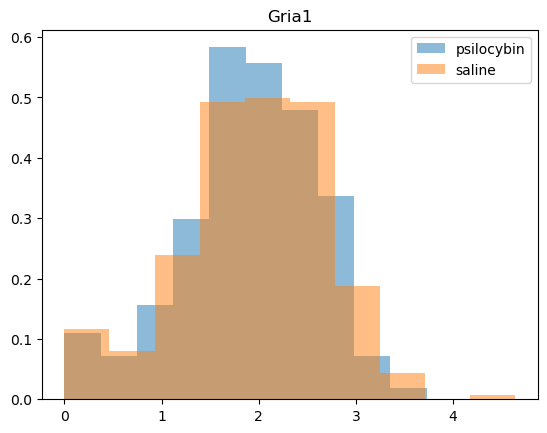

In [80]:
compare_gene(adata, "Gria1", "10", "leiden")

# using boxplots

another way to visualize gene expression for multiple genes in a cluster or multiple clusters in a gene is to use box plots:

In [14]:
genes = ["Slc17a7", "Pvalb", "Sst", "Htr2a", "Pld5"]

In [15]:
saline = adata[adata.obs["condition"] == "saline"]
psilo = adata[adata.obs["condition"] == "psilocybin"]

In [23]:
test = pd.DataFrame(adata.X.toarray())

In [28]:
test.index = adata.obs.index
test.columns = adata.var.index

In [31]:
test = test.join(adata.obs)

In [33]:
import seaborn as sns

In [37]:
df = test[["Gria1", "leiden", "condition"]]

<Axes: xlabel='leiden', ylabel='Gria1'>

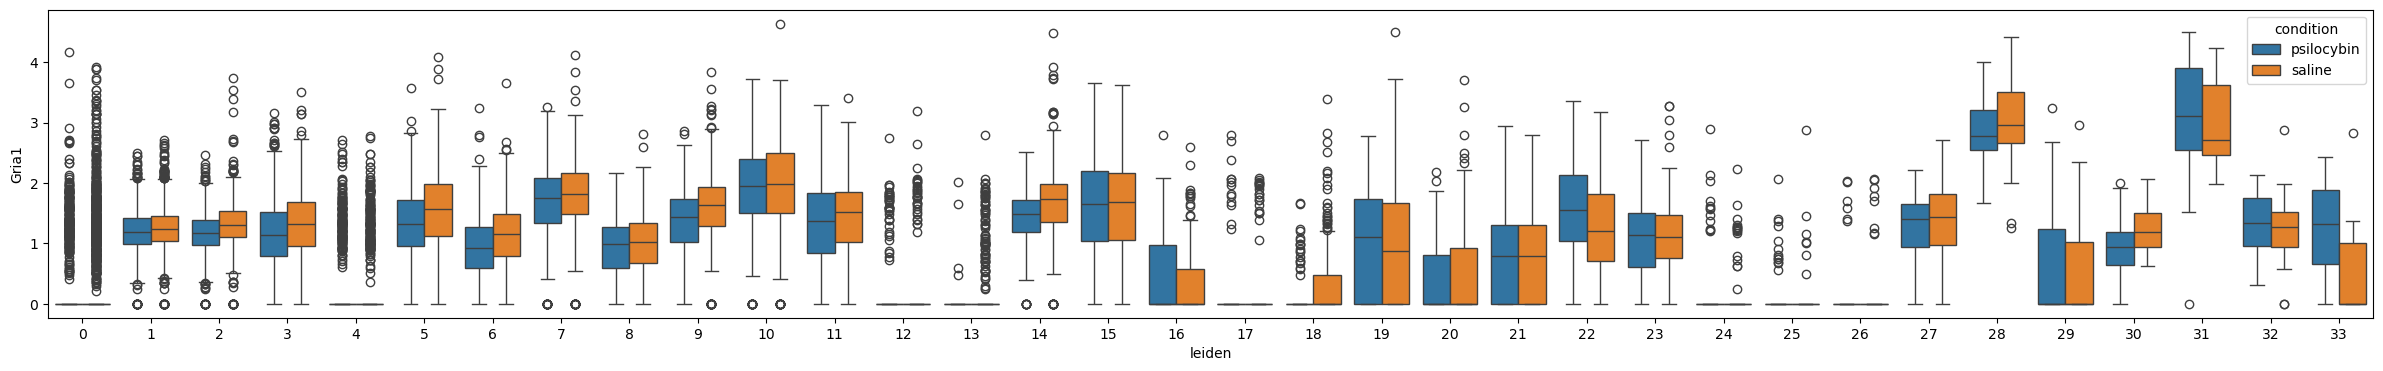

In [44]:
fig, ax = plt.subplots(figsize=(30, 4))
sns.boxplot(data=df, x="leiden", y="Gria1", hue="condition", ax=ax)

# dotplots

for a less quantitative way you could split the two datasets and plot them separately but next to each other:

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


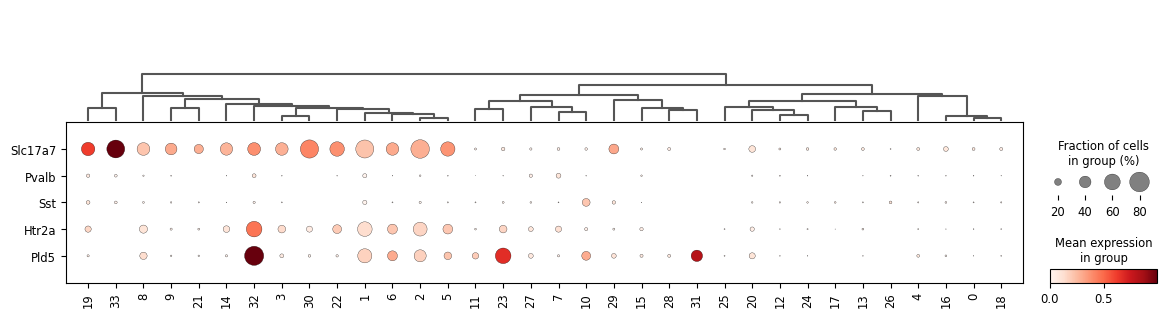

In [17]:
sc.pl.dotplot(saline, groupby="leiden", var_names=genes, swap_axes=True, cmap="Reds", dendrogram=True)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


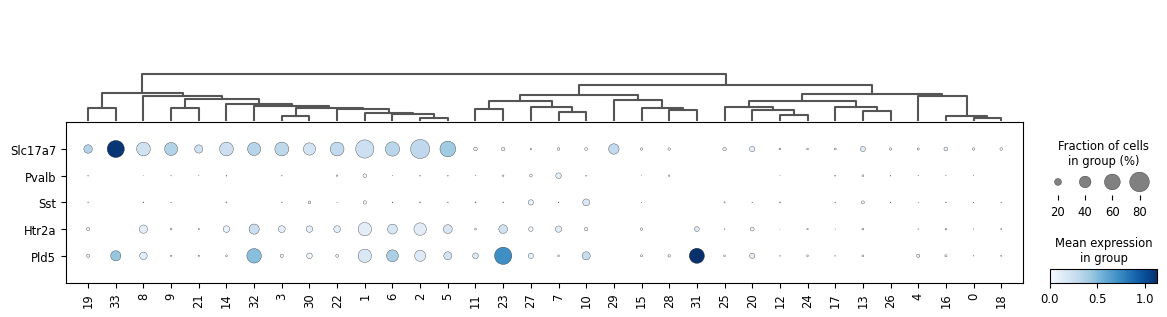

In [20]:
sc.pl.dotplot(psilo, groupby="leiden", var_names=genes, swap_axes=True, cmap="Blues", dendrogram=True)